1. Importing Tensorflow and other libraries

In [ ]:
import pandas as pd
import numpy as np
import glob
import chardet
import io
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import kagglehub
import os

# Traditional ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

Load datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Syed Saqlain Hussain - https://www.kaggle.com/datasets/syedsaqlainhussain/sql-injection-dataset
load sqliv1, sqliv2 and sqliv3

Ayah Khaldi -
https://www.kaggle.com/datasets/ayahkhaldi/sql-injection-dataset
load train

Sajid576 -
https://www.kaggle.com/datasets/sajid576/sql-injection-dataset
load modified sql dataset

In [ ]:
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        raw_data = f.read(10000)
    result = chardet.detect(raw_data)
    return result['encoding']

common_columns = ["Query", "Label"]

directory_path = "/content/datasets"
csv_files = glob.glob(os.path.join(directory_path, "*.csv"))
dataframes = []

for file in csv_files:
    try:
        encoding = detect_encoding(file)
        with open(file, 'r', encoding=encoding, errors='replace') as f:
            file_content = f.read()
        df = pd.read_csv(io.StringIO(file_content), engine='python', on_bad_lines='skip')

        available_cols = [col for col in common_columns if col in df.columns]
        df = df[available_cols]
        dataframes.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")
        continue

if dataframes:
    combined_data = pd.concat(dataframes, ignore_index=True)
    print(combined_data.head())
else:
    print("No dataframes loaded successfully.")

                                               Query  Label
0  The film 'Nightbreed' is one of the best horro...    0.0
1  The story for Hare Rama Hare Krishna actually ...    0.0
2  1" where 6347 = 6347 union all select null,nul...    1.0
3  jk dv1z0r39am1wjiiumia9xrxdowuo87f 110dcc d0ej...    1.0
4  1'||  (  select 'fdkl' where 4572  =  4572 uni...    1.0


Clean the dataset to remove any missing values

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

cleaned_data = combined_data.dropna()

Preprocess dataset

In [ ]:
print(cleaned_data.columns)

Index(['Query', 'Label'], dtype='object')


In [ ]:
cleaned_data['Query'].fillna("", inplace=True)

cleaned_data_sample = cleaned_data.sample(frac=0.4, random_state=42)

vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(cleaned_data_sample['Query']).toarray()
y = cleaned_data_sample['Label'].values

<ipython-input-14-9e9bf7b059e0>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_data['Query'].fillna("", inplace=True)
<ipython-input-14-9e9bf7b059e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Query'].fillna("", inplace=True)


Split dataset

In [ ]:
from sklearn.model_selection import train_test_split
N = 4000

idx = np.random.RandomState(42).choice(X_tfidf.shape[0], size=N, replace=False)
X_sub = X_tfidf[idx]
y_sub = y[idx]

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_sub, y_sub, test_size=0.2, random_state=42, stratify=y_sub
)

## Building the baseline CNN model

In [ ]:
X_train_cnn = X_train_tfidf.reshape(X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1)
X_test_cnn  = X_test_tfidf.reshape(X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1)

# Create a simple CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model fitting

In [ ]:
cnn_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = cnn_model.fit(
    X_train_cnn, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

cnn_preds_prob = cnn_model.predict(X_test_cnn)
cnn_preds = (cnn_preds_prob > 0.5).astype(int).reshape(-1)

cnn_accuracy  = accuracy_score(y_test, cnn_preds)
cnn_precision = precision_score(y_test, cnn_preds, zero_division=0)
cnn_recall    = recall_score(y_test, cnn_preds, zero_division=0)
cnn_f1        = f1_score(y_test, cnn_preds, zero_division=0)

Epoch 1/5
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7165 - loss: 0.5821 - val_accuracy: 0.7519 - val_loss: 0.5114
Epoch 2/5
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7477 - loss: 0.5273 - val_accuracy: 0.7538 - val_loss: 0.5131
Epoch 3/5
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7483 - loss: 0.5302 - val_accuracy: 0.7553 - val_loss: 0.5112
Epoch 4/5
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7449 - loss: 0.5302 - val_accuracy: 0.7596 - val_loss: 0.5092
Epoch 5/5
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7487 - loss: 0.5267 - val_accuracy: 0.7433 - val_loss: 0.5153
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Plotting results

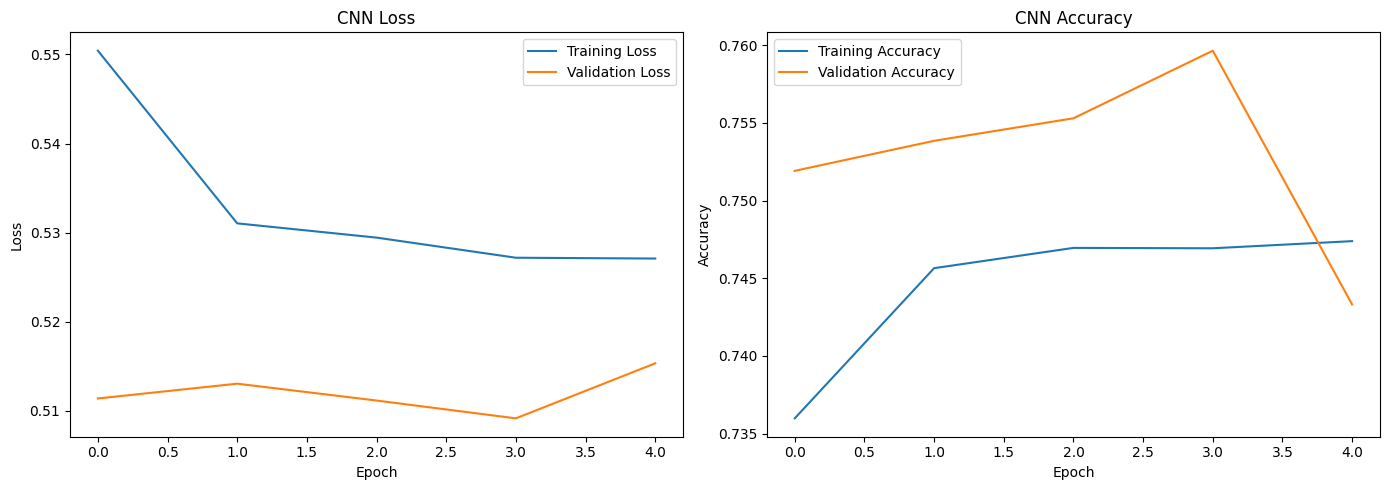

405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
      Metric     Value
0   Accuracy  0.731328
1  Precision  0.702454
2     Recall  0.713051
3   F1 Score  0.707713


In [ ]:
plt.figure(figsize=(14, 5))

# Training/Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training/Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cnn_preds_prob = cnn_model.predict(X_test_cnn)
cnn_preds = (cnn_preds_prob > 0.5).astype(int).reshape(-1)

# Compute evaluation metrics for the CNN baseline
cnn_accuracy = accuracy_score(y_test, cnn_preds)
cnn_precision = precision_score(y_test, cnn_preds, zero_division=0)
cnn_recall = recall_score(y_test, cnn_preds, zero_division=0)
cnn_f1 = f1_score(y_test, cnn_preds, zero_division=0)

# Create a table with the CNN results
cnn_metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [cnn_accuracy, cnn_precision, cnn_recall, cnn_f1]
})

print(cnn_metrics_table)

Logistic Regression, Decision Tree, Random Forest, SVM, Gradient Boosting, Naive Bayes model

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(probability=True),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'Naïve Bayes': MultinomialNB()
}

# List to store result dictionaries.
results_list = []

# Evaluate each model separately.
for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)

    # Predict on the test data.
    y_pred = model.predict(X_test_tfidf)

    # Compute evaluation metrics.
    accuracy_val  = accuracy_score(y_test, y_pred)
    precision_val = precision_score(y_test, y_pred, zero_division=0)
    recall_val    = recall_score(y_test, y_pred, zero_division=0)
    f1_val        = f1_score(y_test, y_pred, zero_division=0)

    # Append the results for the current model as a dictionary.
    results_list.append({
        'Model': model_name,
        'Accuracy': accuracy_val,
        'Precision': precision_val,
        'Recall': recall_val,
        'F1 Score': f1_val
    })

# Convert the list of dictionaries to a DataFrame.
results = pd.DataFrame(results_list)

# Display the comparison table.
print(results)

                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression   0.95375   0.977778  0.923885  0.950067
1        Decision Tree   0.96125   0.980769  0.937008  0.958389
2        Random Forest   0.97125   0.994475  0.944882  0.969044
3                  SVM   0.95875   0.994318  0.918635  0.954980
4    Gradient Boosting   0.95625   0.967568  0.939633  0.953395
5          Naïve Bayes   0.89875   0.882653  0.908136  0.895213


In [ ]:
cnn_result = pd.DataFrame([{
    'Model': 'CNN Baseline',
    'Accuracy': cnn_accuracy,
    'Precision': cnn_precision,
    'Recall': cnn_recall,
    'F1 Score': cnn_f1
}])

# Concatenate the new result with the existing results DataFrame
results = pd.concat([results, cnn_result], ignore_index=True)

# Sort results by F1 Score (or any metric you prefer)
results.sort_values(by='F1 Score', ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)

print("\nComparison Table:")
print(results)


Comparison Table:
                 Model  Accuracy  Precision    Recall  F1 Score
0        Random Forest  0.971250   0.994475  0.944882  0.969044
1        Decision Tree  0.961250   0.980769  0.937008  0.958389
2                  SVM  0.958750   0.994318  0.918635  0.954980
3    Gradient Boosting  0.956250   0.967568  0.939633  0.953395
4  Logistic Regression  0.953750   0.977778  0.923885  0.950067
5          Naïve Bayes  0.898750   0.882653  0.908136  0.895213
6         CNN Baseline  0.731328   0.702454  0.713051  0.707713


Bar chart comparison

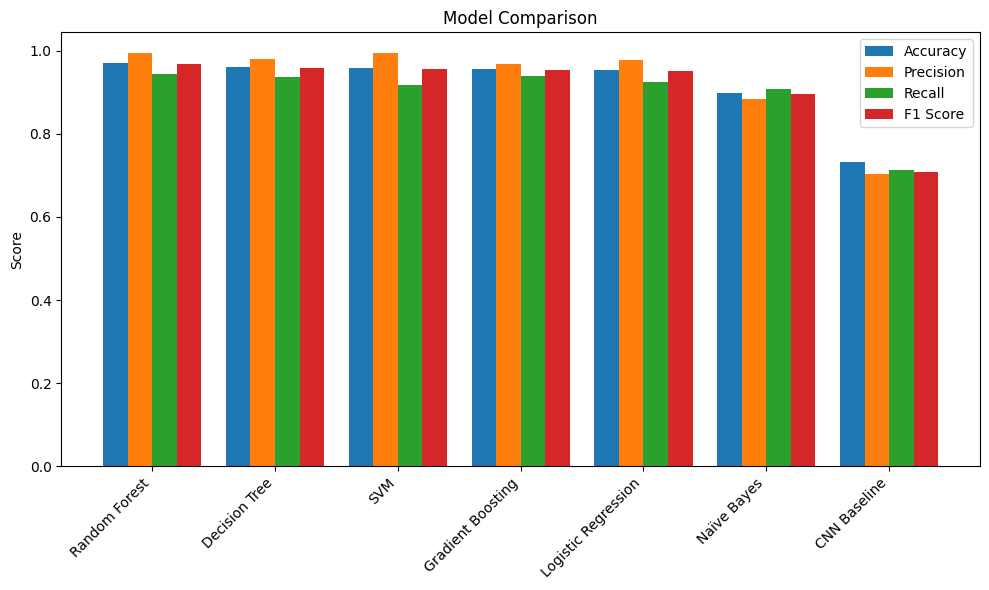

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
models_list = results['Model'].tolist()

# Prepare data for plotting
x = np.arange(len(models_list))  # the label locations
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

# For each metric, we create a bar next to the others
for i, metric in enumerate(metrics):
    values = results[metric].tolist()
    ax.bar(x + (i - 1.5)*width, values, width, label=metric)

# Labeling
ax.set_ylabel('Score')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models_list, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

Random forest performed the best out of the algorithms however this was done with a <500 sample therefore we can manipulate teh parameters in decision tree to get the higest accuruacy

### Test dataset with adversarial inputs is introduced to test the accuracy of the model which is not similar to trained datasets

In [ ]:
from scipy.sparse import issparse

# Load & preprocess test set as before
test_df = pd.read_csv('/content/Test.csv')
test_df['Query'].fillna("", inplace=True)
test_df = test_df.dropna(subset=['Query','Label'])
X_test_tfidf = vectorizer.transform(test_df['Query'])
y_test = test_df['Label'].values

# Your models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(probability=True),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'Naïve Bayes': MultinomialNB()
}

results_list = []
for name, model in models.items():
    # Prepare training & test matrices in the same format
    if name == 'SVM':
        # ensure dense only if it’s sparse
        Xtr = X_train_tfidf.toarray() if issparse(X_train_tfidf) else X_train_tfidf
        Xte = X_test_tfidf.toarray()  if issparse(X_test_tfidf)  else X_test_tfidf
    else:
        Xtr, Xte = X_train_tfidf, X_test_tfidf

    # Fit & predict
    model.fit(Xtr, y_train)
    y_pred = model.predict(Xte)

    # Record metrics
    results_list.append({
        'Model': name,
        'Accuracy':  accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall':    recall_score(y_test, y_pred, zero_division=0),
        'F1 Score':  f1_score(y_test, y_pred, zero_division=0)
    })

# Show comparative results
results_df = pd.DataFrame(results_list)
print(results_df)

<ipython-input-72-8297e0def5e8>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Query'].fillna("", inplace=True)


                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.938081   0.991104  0.877243  0.930704
1        Decision Tree  0.954723   0.956007  0.948109  0.952041
2        Random Forest  0.966563   0.994370  0.934749  0.963638
3                  SVM  0.940712   0.998896  0.875887  0.933356
4    Gradient Boosting  0.957660   0.985347  0.924422  0.953913
5          Naïve Bayes  0.914648   0.949540  0.865948  0.905820


In [ ]:
sorted_results = results_df.sort_values(by='F1 Score', ascending=False)
print(sorted_results)

                 Model  Accuracy  Precision    Recall  F1 Score
2        Random Forest  0.966563   0.994370  0.934749  0.963638
4    Gradient Boosting  0.957660   0.985347  0.924422  0.953913
1        Decision Tree  0.954723   0.956007  0.948109  0.952041
3                  SVM  0.940712   0.998896  0.875887  0.933356
0  Logistic Regression  0.938081   0.991104  0.877243  0.930704
5          Naïve Bayes  0.914648   0.949540  0.865948  0.905820


## Hypertuning Parameters

## Decision tree

### Max_depth
[10,20,30]

Results for different max_depth values:
   max_depth  Accuracy  F1 Score
0         10   0.93375  0.923077
1         20   0.95500  0.948718
2         30   0.95750  0.951567


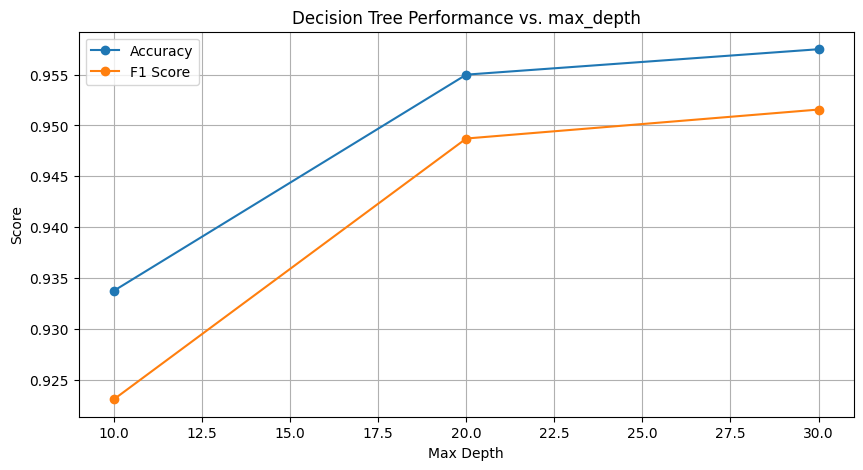

In [ ]:
max_depth_values = [10, 20, 30]

results = []

# Loop over different max_depth values
for depth in max_depth_values:
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_model.fit(X_train_tfidf, y_train)
    y_pred = dt_model.predict(X_test_tfidf)

    accuracy_val = accuracy_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred, zero_division=0)

    results.append({'max_depth': depth, 'Accuracy': accuracy_val, 'F1 Score': f1_val})

results_df = pd.DataFrame(results)
print("Results for different max_depth values:")
print(results_df)

plt.figure(figsize=(10, 5))
plt.plot(results_df['max_depth'], results_df['Accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['max_depth'], results_df['F1 Score'], marker='o', label='F1 Score')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Decision Tree Performance vs. max_depth')
plt.legend()
plt.grid(True)
plt.show()

20 depth produces the highest accuracy and F1 score

A moderate depth that balances capturing data complexity without making the tree too intricate.

### min_samples_split
[2.5,10]

Results for different min_samples_split values:
   min_samples_split  Accuracy  F1 Score
0                  2    0.9600  0.954802
1                  5    0.9575  0.951841
2                 10    0.9575  0.951705


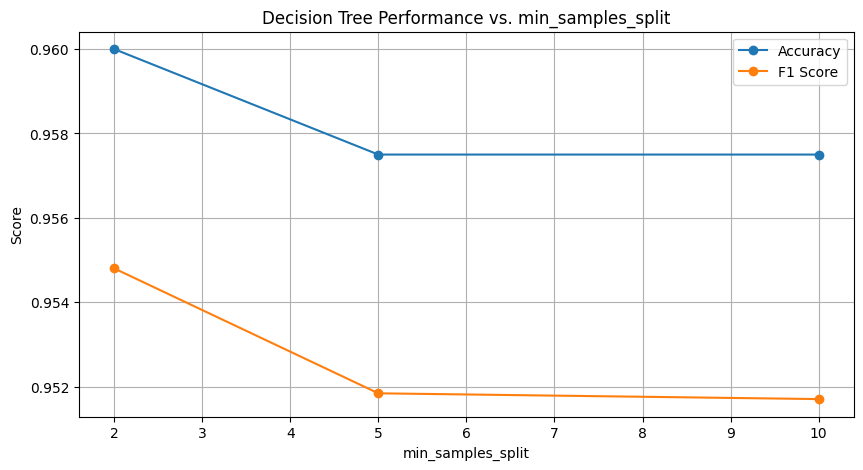

In [ ]:
min_samples_split_values = [2, 5, 10]

results = []

# Loop over different min_samples_split values.
for value in min_samples_split_values:
    dt_model = DecisionTreeClassifier(min_samples_split=value, random_state=42)
    dt_model.fit(X_train_tfidf, y_train)
    y_pred = dt_model.predict(X_test_tfidf)

    accuracy_val = accuracy_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred, zero_division=0)

    results.append({
        'min_samples_split': value,
        'Accuracy': accuracy_val,
        'F1 Score': f1_val
    })

# Convert results to a DataFrame for easier viewing and plotting.
results_df = pd.DataFrame(results)
print("Results for different min_samples_split values:")
print(results_df)

plt.figure(figsize=(10, 5))
plt.plot(results_df['min_samples_split'], results_df['Accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['min_samples_split'], results_df['F1 Score'], marker='o', label='F1 Score')
plt.xlabel('min_samples_split')
plt.ylabel('Score')
plt.title('Decision Tree Performance vs. min_samples_split')
plt.legend(loc='best')
plt.grid(True)
plt.show()

2 samples split produced the highest accuracy score

A more conservative setting that forces splits only when there are at least 2 samples, resulting in a simpler tree that may generalise better.

### min_samples_leaf

[1.2,4]

Results for different min_samples_leaf values:
   min_samples_leaf  Accuracy  F1 Score
0                 1   0.96000  0.954802
1                 2   0.95250  0.945559
2                 4   0.95125  0.944365


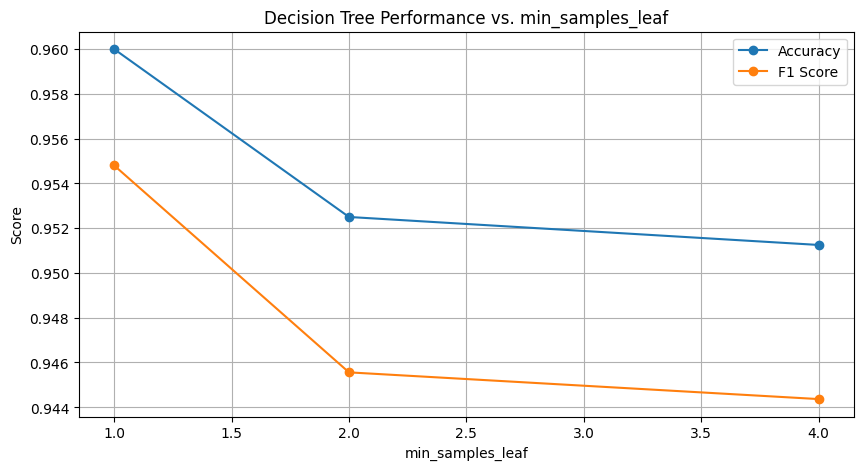

In [ ]:
min_samples_leaf_values = [1, 2, 4]

results = []

# Loop over different min_samples_leaf values.
for value in min_samples_leaf_values:
    dt_model = DecisionTreeClassifier(min_samples_leaf=value, random_state=42)
    dt_model.fit(X_train_tfidf, y_train)
    y_pred = dt_model.predict(X_test_tfidf)

    accuracy_val = accuracy_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred, zero_division=0)

    results.append({
        'min_samples_leaf': value,
        'Accuracy': accuracy_val,
        'F1 Score': f1_val
    })

# Convert results to a DataFrame for easier viewing and plotting.
results_df = pd.DataFrame(results)
print("Results for different min_samples_leaf values:")
print(results_df)

plt.figure(figsize=(10, 5))
plt.plot(results_df['min_samples_leaf'], results_df['Accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['min_samples_leaf'], results_df['F1 Score'], marker='o', label='F1 Score')
plt.xlabel('min_samples_leaf')
plt.ylabel('Score')
plt.title('Decision Tree Performance vs. min_samples_leaf')
plt.legend(loc='best')
plt.grid(True)
plt.show()

1 sample leaf achieves highest accuracy

A moderate number of leaf nodes that allows for some complexity but still limits the overall model size.

### max_leaf_nodes

[10,20,50]

Results for different max_leaf_nodes values:
   max_leaf_nodes  Accuracy  F1 Score
0              10   0.87500  0.851190
1              20   0.92125  0.910638
2              50   0.94625  0.939351


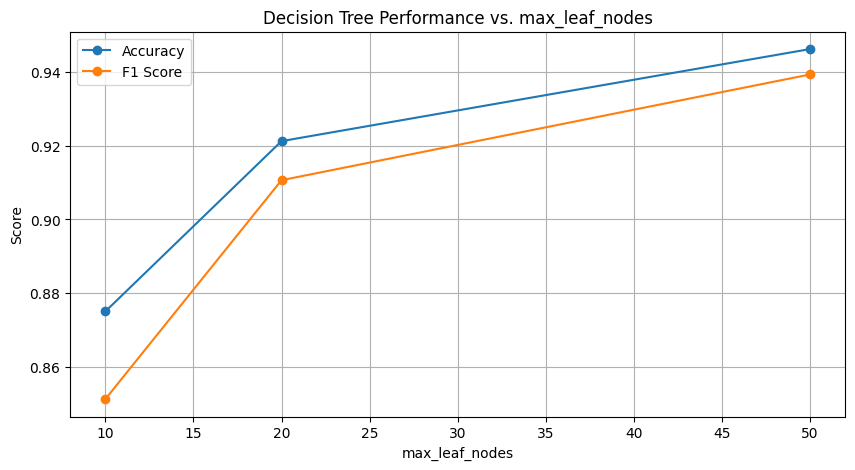

In [ ]:
max_leaf_nodes_values = [10, 20, 50]

results = []

# Loop over different max_leaf_nodes values.
for value in max_leaf_nodes_values:
    dt_model = DecisionTreeClassifier(max_leaf_nodes=value, random_state=42)
    dt_model.fit(X_train_tfidf, y_train)
    y_pred = dt_model.predict(X_test_tfidf)

    accuracy_val = accuracy_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred, zero_division=0)

    results.append({
        'max_leaf_nodes': value,
        'Accuracy': accuracy_val,
        'F1 Score': f1_val
    })

# Convert results to a DataFrame for easier viewing and plotting.
results_df = pd.DataFrame(results)
print("Results for different max_leaf_nodes values:")
print(results_df)

plt.figure(figsize=(10, 5))
plt.plot(results_df['max_leaf_nodes'], results_df['Accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['max_leaf_nodes'], results_df['F1 Score'], marker='o', label='F1 Score')
plt.xlabel('max_leaf_nodes')
plt.ylabel('Score')
plt.title('Decision Tree Performance vs. max_leaf_nodes')
plt.legend(loc='best')
plt.grid(True)
plt.show()

50 max leaf nodes acheived the highest accuracy

A value that allows the tree to capture more detailed patterns, at the risk of increased overfitting if not controlled by other parameters.

### Optimal decision tree model

In [ ]:
dt_model = DecisionTreeClassifier(
    max_depth=14,
    min_samples_split=10,
    min_samples_leaf=1,
    max_leaf_nodes=50,
    random_state=42
)

# Fit the model on training data
dt_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = dt_model.predict(X_test_tfidf)

# Evaluate the model
accuracy_val = accuracy_score(y_test, y_pred)
f1_val = f1_score(y_test, y_pred, zero_division=0)

print("Decision Tree Performance:")
print("Accuracy:", accuracy_val)
print("F1 Score:", f1_val)

Decision Tree Performance:
Accuracy: 0.9475
F1 Score: 0.9403409090909091


### Testing optimal decision tree model

In [ ]:
new_data = pd.read_csv('/content/Test.csv')

new_data = new_data.dropna(subset=['Query', 'Label'])

X_new_tfidf = vectorizer.transform(new_data['Query'])
y_new = new_data['Label'].values

y_new_pred = dt_model.predict(X_new_tfidf)

accuracy_new  = accuracy_score(y_new, y_new_pred)
precision_new = precision_score(y_new, y_new_pred, zero_division=0)
recall_new    = recall_score(y_new, y_new_pred, zero_division=0)
f1_new        = f1_score(y_new, y_new_pred, zero_division=0)

print("Evaluation on New Test Dataset:")
print("Accuracy: ", accuracy_new)
print("Precision:", precision_new)
print("Recall:   ", recall_new)
print("F1 Score: ", f1_new)

Evaluation on New Test Dataset:
Accuracy:  0.9614843367596672
Precision: 0.9781659388646288
Recall:    0.9397186007486769
F1 Score:  0.9585568978570723


## Gradient boosting

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

param_grid = {
    'n_estimators':      [100, 200, 500, 1000],
    'learning_rate':     [0.01, 0.05, 0.1, 0.2],
    'subsample':         [0.6, 0.8, 1.0],
    'max_depth':         [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4, 10],
}

scoring = {'accuracy': 'accuracy', 'f1': 'f1'}
base_clf = GradientBoostingClassifier(random_state=42)


▶ Tuning parameter: n_estimators
  Best n_estimators: 1000


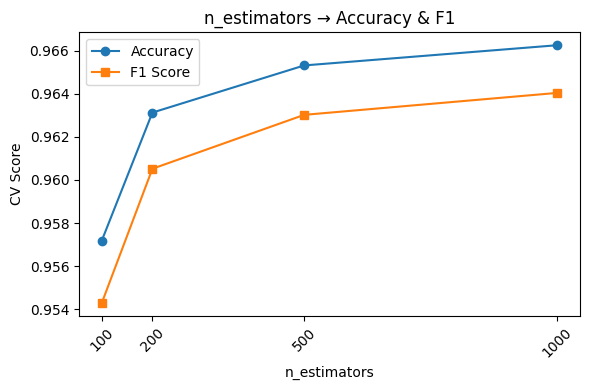


▶ Tuning parameter: learning_rate
  Best learning_rate: 0.2


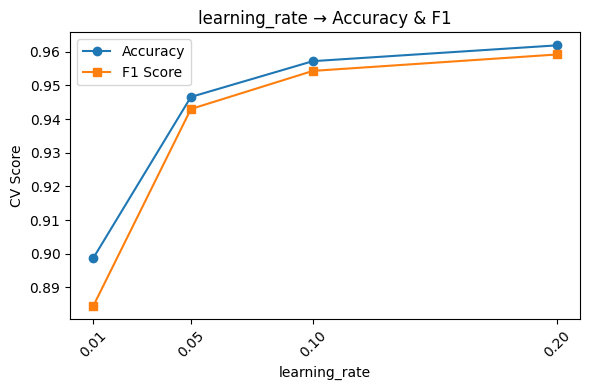


▶ Tuning parameter: subsample
  Best subsample: 0.6


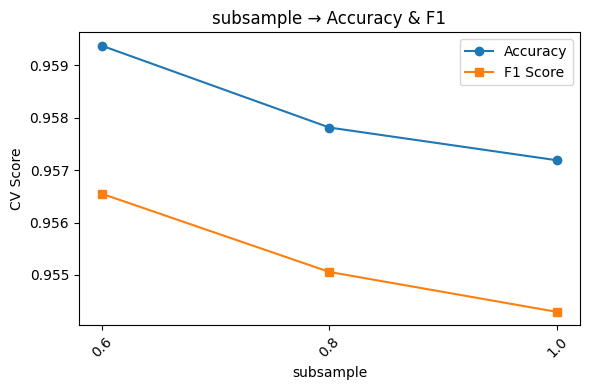


▶ Tuning parameter: max_depth
  Best max_depth: 9


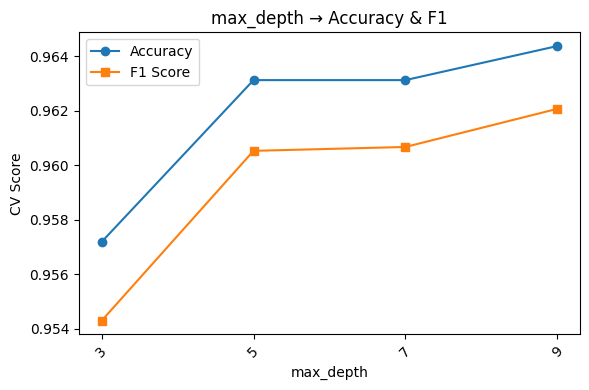


▶ Tuning parameter: min_samples_split
  Best min_samples_split: 10


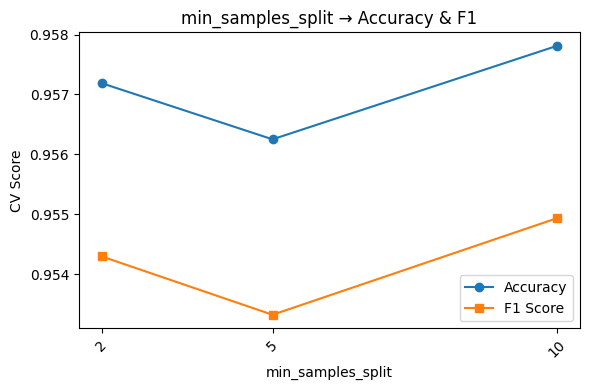


▶ Tuning parameter: min_samples_leaf
  Best min_samples_leaf: 1


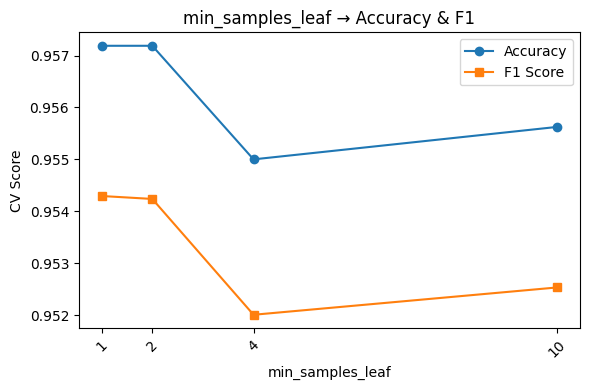

In [ ]:
for param_name, param_values in param_grid.items():
    print(f"\n▶ Tuning parameter: {param_name}")

    # one‑parameter grid
    gs = GridSearchCV(
        estimator=base_clf,
        param_grid={param_name: param_values},
        scoring=scoring,
        refit='accuracy',   # choose best by accuracy
        cv=5,
        n_jobs=-1,
        return_train_score=False
    )

    # fit
    gs.fit(X_train_tfidf, y_train)

    # extract and sort results
    df = pd.DataFrame(gs.cv_results_)
    pivot = (
        df[[f'param_{param_name}', 'mean_test_accuracy', 'mean_test_f1']]
        .drop_duplicates()
        .sort_values(f'param_{param_name}')
    )

    # report best
    print(f"  Best {param_name}: {gs.best_params_[param_name]}")

    # plot
    plt.figure(figsize=(6, 4))
    plt.plot(
        pivot[f'param_{param_name}'],
        pivot['mean_test_accuracy'],
        marker='o', label='Accuracy'
    )
    plt.plot(
        pivot[f'param_{param_name}'],
        pivot['mean_test_f1'],
        marker='s', label='F1 Score'
    )
    plt.xlabel(param_name)
    plt.ylabel('CV Score')
    plt.title(f'{param_name} → Accuracy & F1')
    plt.xticks(pivot[f'param_{param_name}'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

Optimal gradient boosting algorithm

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# 1. Instantiate with your optimal hyperparameters
best_gb = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.2,
    subsample=0.6,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# 2. Fit on your training data
best_gb.fit(X_train_tfidf, y_train)

# 3. Predict on the test set
y_pred = best_gb.predict(X_test_tfidf)

# 4. Evaluate
acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1 Score: {f1:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.9613
Test F1 Score: 0.9564

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97       434
         1.0       0.99      0.93      0.96       366

    accuracy                           0.96       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800

Confusion Matrix:
[[429   5]
 [ 26 340]]


Testing optimal gradient boosting algorithm

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# 1. Load & clean the new data
new_data = pd.read_csv('/content/Test.csv')
new_data = new_data.dropna(subset=['Query', 'Label'])

# 2. Vectorize the SQL queries with the same TF-IDF vectorizer you trained
X_new_tfidf = vectorizer.transform(new_data['Query'])

# 3. True labels
y_new = new_data['Label'].values

# 4. Predict with your best Gradient Boosting model
y_new_pred = best_gb.predict(X_new_tfidf)

# 5. Compute metrics
accuracy_new  = accuracy_score( y_new, y_new_pred )
precision_new = precision_score(y_new, y_new_pred, zero_division=0)
recall_new    = recall_score(   y_new, y_new_pred, zero_division=0)
f1_new        = f1_score(       y_new, y_new_pred, zero_division=0)

# 6. Print summary
print("Evaluation on New Test Dataset (Gradient Boosting):")
print(f"Accuracy:  {accuracy_new:.4f}")
print(f"Precision: {precision_new:.4f}")
print(f"Recall:    {recall_new:.4f}")
print(f"F1 Score:  {f1_new:.4f}\n")

print("Detailed Classification Report:")
print(classification_report(y_new, y_new_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_new, y_new_pred))

Evaluation on New Test Dataset (Gradient Boosting):
Accuracy:  0.9664
Precision: 0.9832
Recall:    0.9453
F1 Score:  0.9638

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     17194
         1.0       0.98      0.95      0.96     15494

    accuracy                           0.97     32688
   macro avg       0.97      0.97      0.97     32688
weighted avg       0.97      0.97      0.97     32688

Confusion Matrix:
[[16943   251]
 [  848 14646]]


# Support vector machine (SVM)


▶ Tuning parameter: C
  Best C: 10


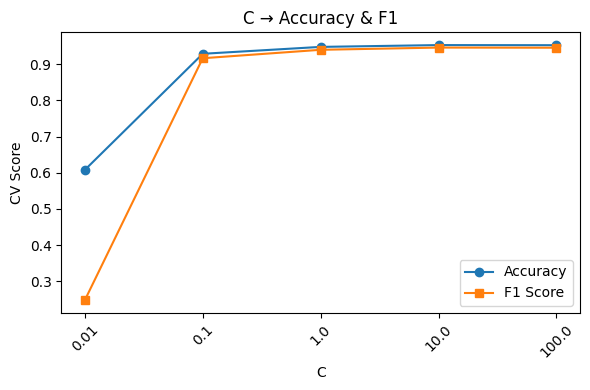


▶ Tuning parameter: kernel
  Best kernel: linear


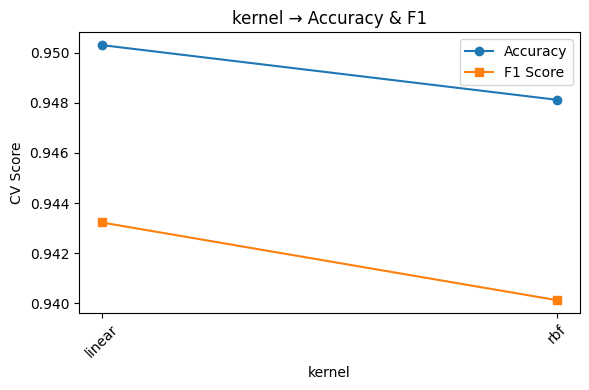


▶ Tuning parameter: gamma
  Best gamma: 1


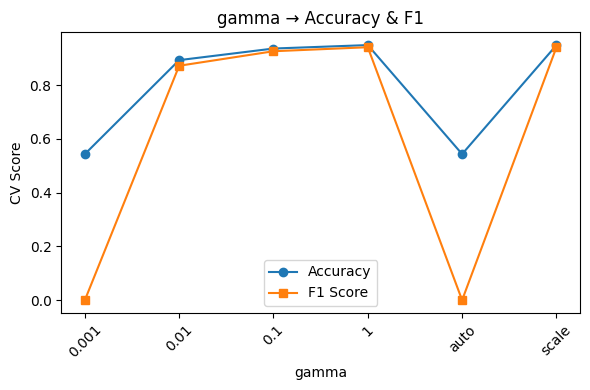


▶ Tuning parameter: tol
  Best tol: 0.0001


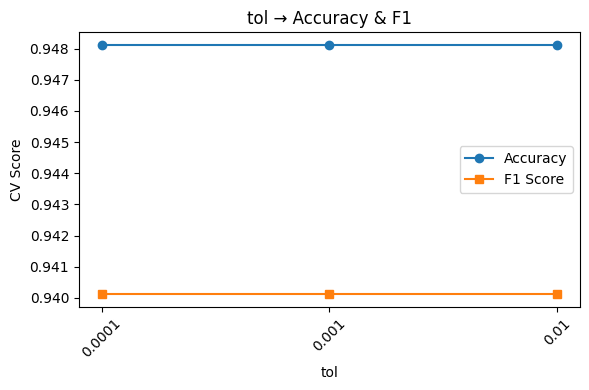


▶ Tuning parameter: shrinking
  Best shrinking: True


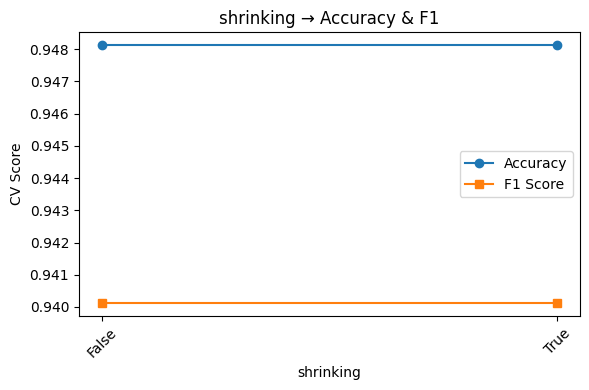


▶ Tuning parameter: max_iter
  Best max_iter: -1


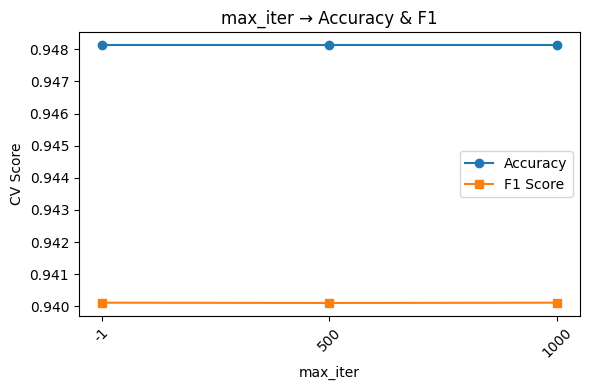


▶ Tuning parameter: decision_function_shape
  Best decision_function_shape: ovr


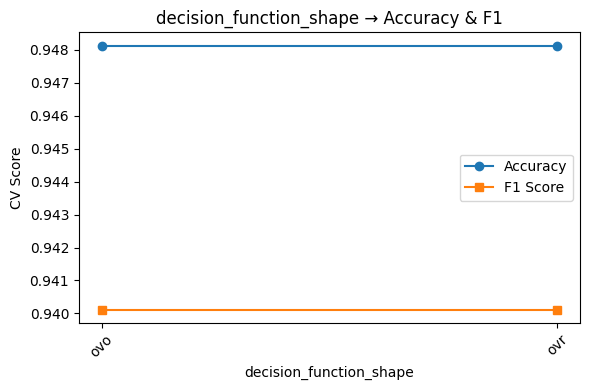

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd

param_grid = {
    'C':                        [0.01, 0.1, 1, 10, 100],
    'kernel':                   ['linear', 'rbf'],
    'gamma':                    ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'tol':                      [1e-4, 1e-3, 1e-2],
    'shrinking':                [True, False],
    'max_iter':                 [-1, 500, 1000],
    'decision_function_shape':  ['ovr', 'ovo'],
}

scoring  = {'accuracy': 'accuracy', 'f1': 'f1'}
base_clf = SVC(random_state=42, probability=True)

for param_name, param_values in param_grid.items():
    print(f"\n▶ Tuning parameter: {param_name}")

    gs = GridSearchCV(
        estimator=base_clf,
        param_grid={param_name: param_values},
        scoring=scoring,
        refit='accuracy',
        cv=5,
        n_jobs=-1,
        return_train_score=False
    )
    gs.fit(X_train_tfidf, y_train)

    # gather results
    df = pd.DataFrame(gs.cv_results_)
    col = f'param_{param_name}'
    pivot = df[[col, 'mean_test_accuracy', 'mean_test_f1']].drop_duplicates()

    if pivot[col].map(type).nunique() > 1:
        pivot[col] = pivot[col].astype(str)
    try:
        pivot = pivot.sort_values(col)
    except TypeError:
        pass

    print(f"  Best {param_name}: {gs.best_params_[param_name]}")

    # plot
    x = pivot[col].astype(str)
    plt.figure(figsize=(6, 4))
    plt.plot(x, pivot['mean_test_accuracy'], marker='o', label='Accuracy')
    plt.plot(x, pivot['mean_test_f1'],      marker='s', label='F1 Score')
    plt.xlabel(param_name)
    plt.ylabel('CV Score')
    plt.title(f'{param_name} → Accuracy & F1')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

Optimal SVM algorithm

In [ ]:
svm_opt = SVC(
    C=10,
    kernel='linear',
    gamma=1,
    probability=True,
    random_state=42
)

# 5. Fit on training data
svm_opt.fit(X_train_tfidf, y_train)

# 6. Predict & evaluate on test data
y_pred = svm_opt.predict(X_test_tfidf)

acc       = accuracy_score( y_test,      y_pred )
precision = precision_score(y_test,      y_pred, zero_division=0)
recall    = recall_score(   y_test,      y_pred, zero_division=0)
f1        = f1_score(       y_test,      y_pred, zero_division=0)

print("Test Performance of Optimal SVM:")
print(f"  Accuracy : {acc:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall   : {recall:.4f}")
print(f"  F1 Score : {f1:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Performance of Optimal SVM:
  Accuracy : 0.9325
  Precision: 0.9432
  Recall   : 0.9071
  F1 Score : 0.9248

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94       434
         1.0       0.94      0.91      0.92       366

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800

Confusion Matrix:
[[414  20]
 [ 34 332]]


Testing optimal SVM algorithm

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

new_data = pd.read_csv('/content/Test.csv')
new_data = new_data.dropna(subset=['Query','Label'])

# 2. Vectorize then densify
X_new_tfidf = vectorizer.transform(new_data['Query'])
X_new_dense = X_new_tfidf.toarray()

# 3. True labels
y_new = new_data['Label'].values

# 4. Predict on dense
y_new_pred = svm_opt.predict(X_new_dense)

# 5. Metrics
print("Accuracy:",  accuracy_score(y_new, y_new_pred))
print("Precision:", precision_score(y_new, y_new_pred, zero_division=0))
print("Recall:   ", recall_score(y_new, y_new_pred, zero_division=0))
print("F1 Score: ", f1_score(y_new, y_new_pred, zero_division=0))
print("\nClassification Report:\n", classification_report(y_new, y_new_pred))
print("Confusion Matrix:\n", confusion_matrix(y_new, y_new_pred))

Accuracy: 0.9311062163485071
Precision: 0.9410471622701838
Recall:    0.911772298954434
F1 Score:  0.9261784566970432

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.95      0.94     17194
         1.0       0.94      0.91      0.93     15494

    accuracy                           0.93     32688
   macro avg       0.93      0.93      0.93     32688
weighted avg       0.93      0.93      0.93     32688

Confusion Matrix:
 [[16309   885]
 [ 1367 14127]]


# Logistic regression


▶ Tuning parameter: C
  Best C: 10


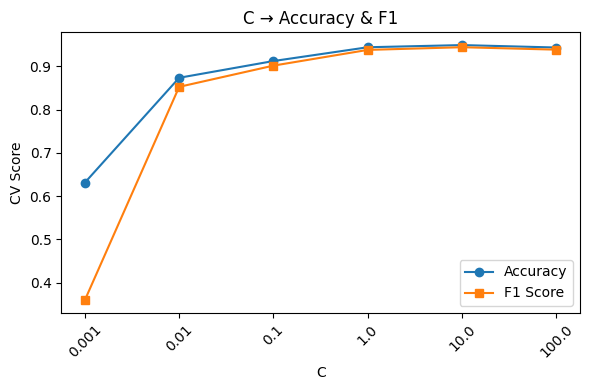


▶ Tuning parameter: penalty
  Best penalty: l1


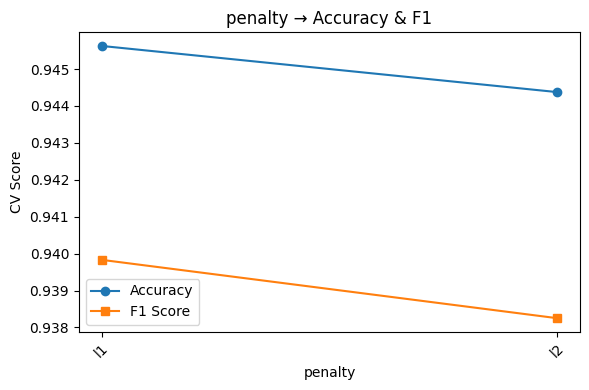


▶ Tuning parameter: tol
  Best tol: 1e-05


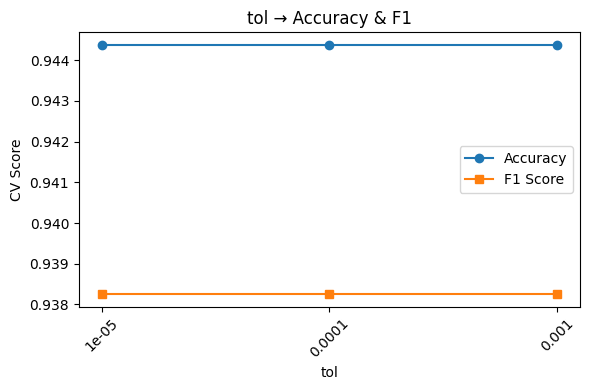


▶ Tuning parameter: class_weight
  Best class_weight: balanced


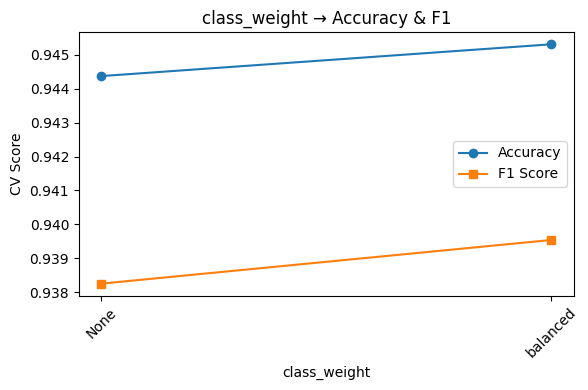


▶ Tuning parameter: max_iter
  Best max_iter: 100


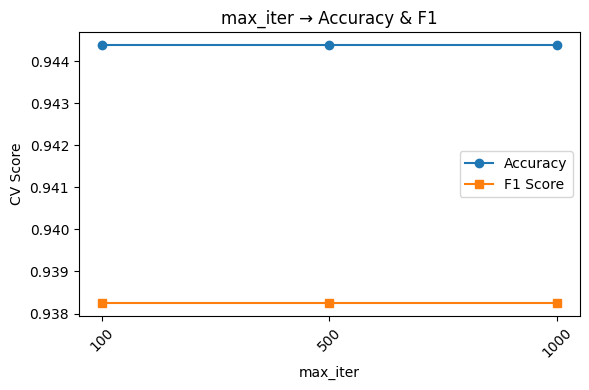

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# 1. Define the hyperparameter grid for LogisticRegression
param_grid = {
    'C':            [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty':      ['l1', 'l2'],
    'tol':          [1e-5, 1e-4, 1e-3],
    'class_weight': [None, 'balanced'],
    'max_iter':     [100, 500, 1000]
}

scoring  = {'accuracy': 'accuracy', 'f1': 'f1'}
base_clf = LogisticRegression(solver='liblinear', random_state=42)

# 2. Loop over each parameter one at a time
for param_name, param_values in param_grid.items():
    print(f"\n▶ Tuning parameter: {param_name}")

    # set up a one-dimensional GridSearch for this parameter
    gs = GridSearchCV(
        estimator=base_clf,
        param_grid={param_name: param_values},
        scoring=scoring,
        refit='accuracy',
        cv=5,
        n_jobs=-1,
        return_train_score=False
    )

    # 3. Fit on training data
    gs.fit(X_train_tfidf, y_train)

    # 4. Extract CV results
    df = pd.DataFrame(gs.cv_results_)
    col = f'param_{param_name}'
    pivot = (
        df[[col, 'mean_test_accuracy', 'mean_test_f1']]
        .drop_duplicates()
    )

    # 5. Sort values
    if pivot[col].map(type).nunique() > 1:
        pivot[col] = pivot[col].astype(str)
    try:
        pivot = pivot.sort_values(col)
    except TypeError:
        pass

    print(f"  Best {param_name}: {gs.best_params_[param_name]}")

    # 6. Plot Accuracy & F1 vs this hyperparameter
    x = pivot[col].astype(str)
    plt.figure(figsize=(6, 4))
    plt.plot(x, pivot['mean_test_accuracy'], marker='o', label='Accuracy')
    plt.plot(x, pivot['mean_test_f1'],      marker='s', label='F1 Score')
    plt.xlabel(param_name)
    plt.ylabel('CV Score')
    plt.title(f'{param_name} → Accuracy & F1')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

Optimal logistic regression model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# 1. Instantiate the “optimal” Logistic Regression with chosen hyperparameters
lr_opt = LogisticRegression(
    C=10,
    penalty='l1',
    class_weight='balanced',
    solver='liblinear',
    random_state=42,
    max_iter=1000
)

# 2. Fit on your training TF-IDF features
lr_opt.fit(X_train_tfidf, y_train)

# 3. Predict on the test set
y_pred = lr_opt.predict(X_test_tfidf)

# 4. Evaluate performance
acc       = accuracy_score( y_test,      y_pred )
precision = precision_score(y_test,      y_pred, zero_division=0)
recall    = recall_score(   y_test,      y_pred, zero_division=0)
f1        = f1_score(       y_test,      y_pred, zero_division=0)

print("Optimal Logistic Regression Test Performance:")
print(f"  Accuracy : {acc:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall   : {recall:.4f}")
print(f"  F1 Score : {f1:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Optimal Logistic Regression Test Performance:
  Accuracy : 0.9437
  Precision: 0.9439
  Recall   : 0.9363
  F1 Score : 0.9401

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95       423
         1.0       0.94      0.94      0.94       377

    accuracy                           0.94       800
   macro avg       0.94      0.94      0.94       800
weighted avg       0.94      0.94      0.94       800

Confusion Matrix:
[[402  21]
 [ 24 353]]


Applying Ridge regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

lr_ridge = LogisticRegression(
    C=10,
    penalty='l2',
    class_weight='balanced',
    solver='liblinear',
    random_state=42,
    max_iter=1000
)

# fit & evaluate
lr_ridge.fit(X_train_tfidf, y_train)
y_pred = lr_ridge.predict(X_test_tfidf)

print("Ridge-penalized Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Ridge-penalized Logistic Regression
Accuracy: 0.9525
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96       423
         1.0       0.96      0.93      0.95       377

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800



Testing optimal logistic regression model

In [ ]:
# 1. Load & clean your new test set
new_data = pd.read_csv('/content/Test.csv')
new_data = new_data.dropna(subset=['Query','Label'])

# 2. Extract features & labels
X_new_sql = new_data['Query']
y_new      = new_data['Label'].values

# 3. Vectorize using the TF-IDF you fit on training data
X_new_tfidf = vectorizer.transform(X_new_sql)

# 4. Predict with your tuned RidgeClassifier
y_new_pred = lr_ridge.predict(X_new_tfidf)

# 5. Compute and print evaluation metrics
acc       = accuracy_score( y_new,      y_new_pred )
precision = precision_score(y_new,      y_new_pred, zero_division=0)
recall    = recall_score(   y_new,      y_new_pred, zero_division=0)
f1        = f1_score(       y_new,      y_new_pred, zero_division=0)

print("Evaluation on New Test Dataset (Tuned RidgeClassifier):")
print(f"  Accuracy : {acc:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall   : {recall:.4f}")
print(f"  F1 Score : {f1:.4f}\n")

print("Classification Report:")
print(classification_report(y_new, y_new_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_new, y_new_pred))

Evaluation on New Test Dataset (Tuned RidgeClassifier):
  Accuracy : 0.9467
  Precision: 0.9798
  Recall   : 0.9063
  F1 Score : 0.9416

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     17194
         1.0       0.98      0.91      0.94     15494

    accuracy                           0.95     32688
   macro avg       0.95      0.94      0.95     32688
weighted avg       0.95      0.95      0.95     32688

Confusion Matrix:
[[16904   290]
 [ 1452 14042]]


# Naive Bayes


▶ Tuning parameter: alpha
  Best alpha: 0.01


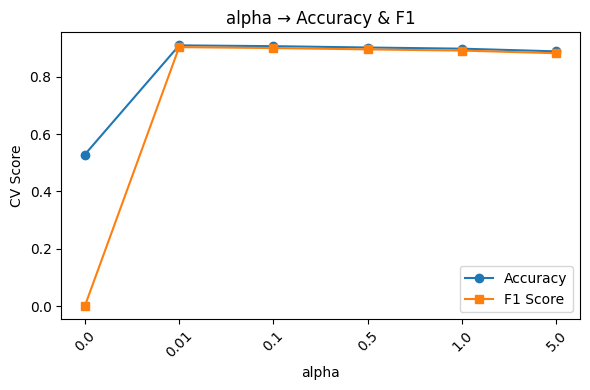


▶ Tuning parameter: fit_prior
  Best fit_prior: True


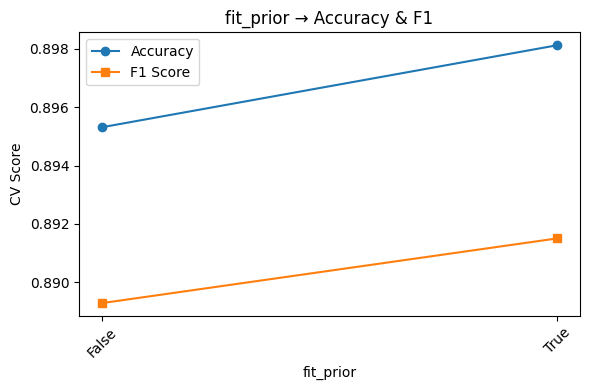

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# 1. Define the hyper-parameters to sweep for MultinomialNB
param_grid = {
    'alpha':     [0.0, 1e-2, 0.1, 0.5, 1.0, 5.0],
    'fit_prior': [True, False]
}

scoring  = {'accuracy': 'accuracy', 'f1': 'f1'}
base_clf = MultinomialNB()

# 2. For each parameter, run a one-dimensional GridSearchCV and plot
for param_name, param_values in param_grid.items():
    print(f"\n▶ Tuning parameter: {param_name}")

    gs = GridSearchCV(
        estimator=base_clf,
        param_grid={param_name: param_values},
        scoring=scoring,
        refit='accuracy',
        cv=5,
        n_jobs=-1,
        return_train_score=False
    )
    gs.fit(X_train_tfidf, y_train)

    # 3. Extract CV results
    df = pd.DataFrame(gs.cv_results_)
    col = f'param_{param_name}'
    pivot = (
        df[[col, 'mean_test_accuracy', 'mean_test_f1']]
        .drop_duplicates()
    )

    # 4. Sort values (cast to string if mixed types)
    if pivot[col].map(type).nunique() > 1:
        pivot[col] = pivot[col].astype(str)
    try:
        pivot = pivot.sort_values(col)
    except TypeError:
        pass

    print(f"  Best {param_name}: {gs.best_params_[param_name]}")

    # 5. Plot Accuracy & F1 vs this hyperparameter
    x = pivot[col].astype(str)
    plt.figure(figsize=(6, 4))
    plt.plot(x, pivot['mean_test_accuracy'], marker='o', label='Accuracy')
    plt.plot(x, pivot['mean_test_f1'],      marker='s', label='F1 Score')
    plt.xlabel(param_name)
    plt.ylabel('CV Score')
    plt.title(f'{param_name} → Accuracy & F1')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

Optimal Naive bayes model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# 1. Instantiate the optimal MultinomialNB
nb_opt = MultinomialNB(
    alpha=0.01,
    fit_prior=True
)

# 2. Fit on your training TF-IDF features
nb_opt.fit(X_train_tfidf, y_train)

# 3. Predict on your held-out test TF-IDF
y_pred = nb_opt.predict(X_test_tfidf)

# 4. Evaluate
acc       = accuracy_score( y_test,      y_pred )
precision = precision_score(y_test,      y_pred, zero_division=0)
recall    = recall_score(   y_test,      y_pred, zero_division=0)
f1        = f1_score(       y_test,      y_pred, zero_division=0)

print("Optimal MultinomialNB Test Performance:")
print(f"  Accuracy : {acc:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall   : {recall:.4f}")
print(f"  F1 Score : {f1:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Optimal MultinomialNB Test Performance:
  Accuracy : 0.8988
  Precision: 0.8915
  Recall   : 0.8939
  F1 Score : 0.8927

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90       423
         1.0       0.89      0.89      0.89       377

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800

Confusion Matrix:
[[382  41]
 [ 40 337]]


Testing optimal naive bayes model

In [ ]:
# 1. Load & clean new test data
new_data = pd.read_csv('/content/Test.csv')
new_data = new_data.dropna(subset=['Query','Label'])

# 2. Extract raw features & true labels
X_new_sql = new_data['Query']
y_new      = new_data['Label'].values

# 3. Vectorize using your trained TF-IDF vectorizer
X_new_tfidf = vectorizer.transform(X_new_sql)

# 4. Predict with the optimal MultinomialNB you trained (nb_opt)
y_new_pred = nb_opt.predict(X_new_tfidf)

# 5. Compute evaluation metrics
acc       = accuracy_score( y_new,      y_new_pred )
precision = precision_score(y_new,      y_new_pred, zero_division=0)
recall    = recall_score(   y_new,      y_new_pred, zero_division=0)
f1        = f1_score(       y_new,      y_new_pred, zero_division=0)

print("Evaluation on New Test Dataset (Optimal MultinomialNB):")
print(f"  Accuracy : {acc:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall   : {recall:.4f}")
print(f"  F1 Score : {f1:.4f}\n")

print("Classification Report:")
print(classification_report(y_new, y_new_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_new, y_new_pred))

Evaluation on New Test Dataset (Optimal MultinomialNB):
  Accuracy : 0.9208
  Precision: 0.9528
  Recall   : 0.8763
  F1 Score : 0.9130

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93     17194
         1.0       0.95      0.88      0.91     15494

    accuracy                           0.92     32688
   macro avg       0.92      0.92      0.92     32688
weighted avg       0.92      0.92      0.92     32688

Confusion Matrix:
[[16522   672]
 [ 1917 13577]]


Final results

## Overfitting CNN model

Creating dense 3d array

In [ ]:
X_train_dense = X_train_tfidf
X_test_dense = X_test_tfidf

X_train_cnn = X_train_dense.reshape(X_train_dense.shape[0], X_train_dense.shape[1], 1)
X_test_cnn  = X_test_dense.reshape(X_test_dense.shape[0], X_test_dense.shape[1], 1)

In [ ]:
model = Sequential([
    # First convolutional block with BatchNormalization
    Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    BatchNormalization(),

    # Second convolutional block
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),

    # Global pooling to reduce dimensionality
    GlobalMaxPooling1D(),

    # Dense layers with dropout for regularization
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for 30 epochs
history = model.fit(
    X_train_cnn, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6035 - loss: 2.2584 - val_accuracy: 0.5916 - val_loss: 0.6369
Epoch 2/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6983 - loss: 0.5778 - val_accuracy: 0.7311 - val_loss: 0.5882
Epoch 3/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6827 - loss: 0.5874 - val_accuracy: 0.7389 - val_loss: 0.5617
Epoch 4/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6877 - loss: 0.5834 - val_accuracy: 0.7330 - val_loss: 0.5860
Epoch 5/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6784 - loss: 0.5863 - val_accuracy: 0.7384 - val_loss: 0.5555
Epoch 6/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6963 - loss: 0.5858 - val_accuracy: 0.7548 - val_loss: 0.5655
Epoch 7/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7034 - loss: 0.5607 - val_accuracy: 0.7403 - val_loss: 0.5539
Epoch 8/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7144 - loss: 0.5550 - val_accuracy:

In [ ]:
y_pred_prob = model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

cnn_accuracy = accuracy_score(y_test, y_pred)
cnn_precision = precision_score(y_test, y_pred, zero_division=0)
cnn_recall = recall_score(y_test, y_pred, zero_division=0)
cnn_f1 = f1_score(y_test, y_pred, zero_division=0)

print("\nCNN Model Evaluation on Test Dataset:")
print("Accuracy:", cnn_accuracy)
print("Precision:", cnn_precision)
print("Recall:", cnn_recall)
print("F1 Score:", cnn_f1)

1290/1290 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

CNN Model Evaluation on Test Dataset:
Accuracy: 0.751926152056985
Precision: 0.6696523517382413
Recall: 0.8833558133261398
F1 Score: 0.7618006281260905


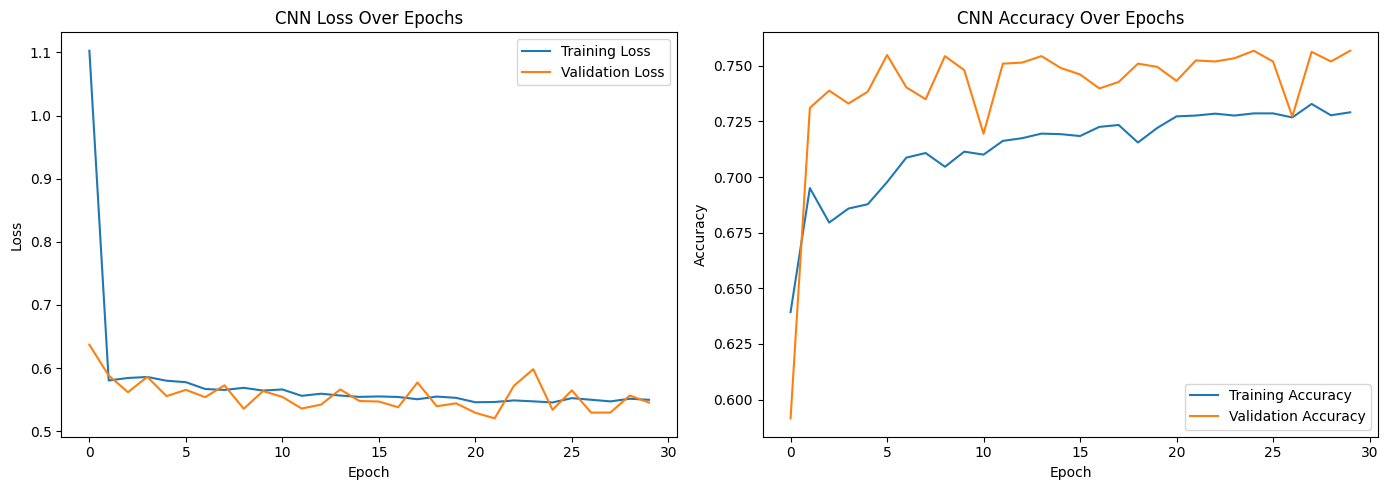

In [ ]:
plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Similar study report

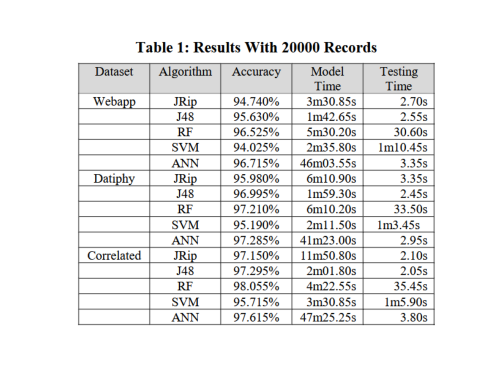

In [ ]:
img = mpimg.imread('/similar_study.PNG')
plt.imshow(img)
plt.axis('off')
plt.show()